In [2]:
import pandas as pd
import numpy as np


# preprocessing and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import pywt
from umap import UMAP


# visualization
import matplotlib.pyplot as plt
import plotly.express as px


AMPLITUDE_THRESHOLD = 0.06


df = pd.read_csv("/home/alpha/programs/python_files/datasets/cnv_and_mut/entities_transformed.csv")

# basic filtering. Rename Unnamded 0 with ID. Dropp chromosomes Y and X
# df = df.dropna(axis=1)
# df = df.fillna(0)
# df = df.rename(columns={"Unnamed: 0": "ID"})
df = df[df.columns.drop(list(df.filter(regex='[YX]')))]

print(df.head())
# Make it amplitude agnostic (experimental) 
def stupid_custom_filter(df=df,AMPLITUDE_THRESHOLD=AMPLITUDE_THRESHOLD):
    # temporary drop non digit columns
    helper_df = df[["entity","ID"]]
    df = df.drop(columns=["entity","ID"])
    # standardize and normalize data
    df = (df-df.mean())/df.std()
    df = 2*((df-df.min())/(df.max()-df.min()))-1
    # apply the filter
    df[df < -AMPLITUDE_THRESHOLD] = -1
    df[df > AMPLITUDE_THRESHOLD] = 1
    df[(df <= AMPLITUDE_THRESHOLD) & (df >= -AMPLITUDE_THRESHOLD)] = 0
    # append the dropped columns on the filtered dataframe
    df["ID"] = helper_df["ID"]
    df["entity"] = helper_df["entity"]
    
    return df

# df = stupid_custom_filter()



# Make features
features = df.columns.tolist()
features.remove("entity")
features.remove("ID")

print(df.head())

/home/alpha/miniconda3/envs/science/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alpha/miniconda3/envs/science/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alpha/miniconda3/envs/science/lib/python3.11/site-packages/uma

                    ID         0         1         2         3         4  \
0  206054070144_R04C01 -0.206122 -0.434517 -0.328805 -0.457852 -0.282843   
1  207343240049_R06C01 -0.604223 -0.908279 -0.755190 -1.067731 -0.931967   
2  203273200231_R06C01 -0.140007 -0.202586 -0.319612 -0.586545 -0.467044   
3  205041760139_R08C01 -0.017324 -0.171120 -0.213193 -0.253498 -0.077428   
4  205617070063_R08C01 -0.048790 -0.160160 -0.179252 -0.182080 -0.222032   

          5         6         7         8  ...      1932      1933      1934  \
0 -0.318552 -0.300167 -0.214960 -0.096167  ... -0.174655 -0.310420 -0.245366   
1 -0.969797 -0.803980 -0.971918 -0.383959  ... -0.166170 -0.325623 -0.171473   
2 -0.475529 -0.409415 -0.569928 -0.432749  ... -0.216375 -0.247487 -0.075307   
3  0.100056  0.076721 -0.083439 -0.088388  ...  0.050205 -0.041366 -0.004596   
4 -0.259862 -0.058690 -0.283550 -0.268347  ... -0.551190 -0.308652 -0.318905   

       1935      1936      1937      1938      1939      1940 

## Standardization and denoising using PCA

### Best settings so far

*Master file builder*

file["value"] = 2*((file["value"]-file["value"].min())/(file["value"].max()-file["value"].min()))-1

file["value"] = (file["value"]-file["value"].mean())/file["value"].std()

*Preprocessing*

PRINCIPAL_COMPONENTS = 5
StandardScaler
N_NEIGHBORS = 10


Scaler to use (default StandardSclaer) : 
 1.StandardScaler 
 2.MinMaxScaler 
 3.RobustScaler 
 4.QuantileTransformer 
 5. Normalizer 
 3


[0.15194407 0.1220048  0.0698077  0.05956985 0.04701756 0.04549002
 0.03412264 0.03196018 0.03071748 0.02545634 0.02266527 0.01919677
 0.01585631 0.01443147 0.01393399] 4.068704263953084


Text(0, 0.5, 'variance %')

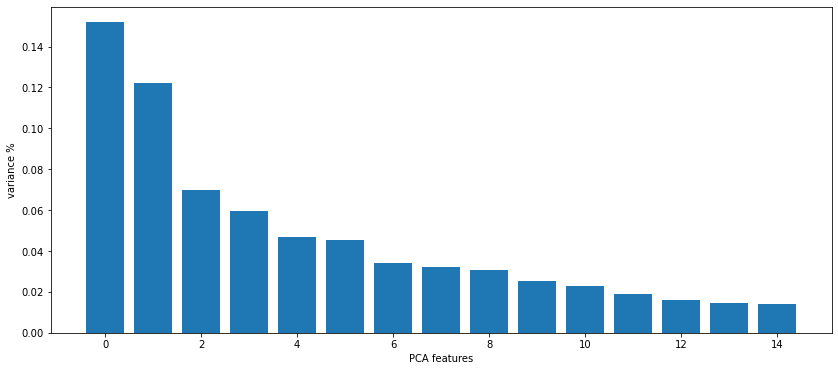

In [3]:
PRINCIPAL_COMPONENTS = 15

# make targets
x = df.loc[:,features].values
y_entity = df.loc[:,"entity"].values
y_id = df.loc[:,"ID"].values


# test transform and preprocessing methods
def custom_preprocess(method=1,x=x):
    if method == 2:
        scaler = MinMaxScaler()
    elif method == 3:
        scaler = RobustScaler(quantile_range=(0.2,0.8))
    elif method == 4:
        scaler = QuantileTransformer(n_quantiles=10, random_state=0, output_distribution="normal")
    elif method == 5:
        scaler = Normalizer()
    else:
        print("using default StandardScaler")
        scaler = StandardScaler()
    
    x = scaler.fit_transform(x)
    # x = Normalizer(norm="max").fit_transform(x)
    return x
    
method = int(input("Scaler to use (default StandardSclaer) : \n 1.StandardScaler \n 2.MinMaxScaler \n 3.RobustScaler \n 4.QuantileTransformer \n 5. Normalizer \n"))
x = custom_preprocess(method,x)


# PCA
pca_denoize = PCA(n_components=PRINCIPAL_COMPONENTS)
denoize = pca_denoize.fit_transform(x)
# print components which contribute to variance the most
variance = pca_denoize.explained_variance_ratio_
noise = pca_denoize.noise_variance_
print(variance, noise)

plt.figure(figsize=[14,6])
plt.bar(range(variance.shape[0]),variance)
plt.xlabel('PCA features')
plt.ylabel('variance %')


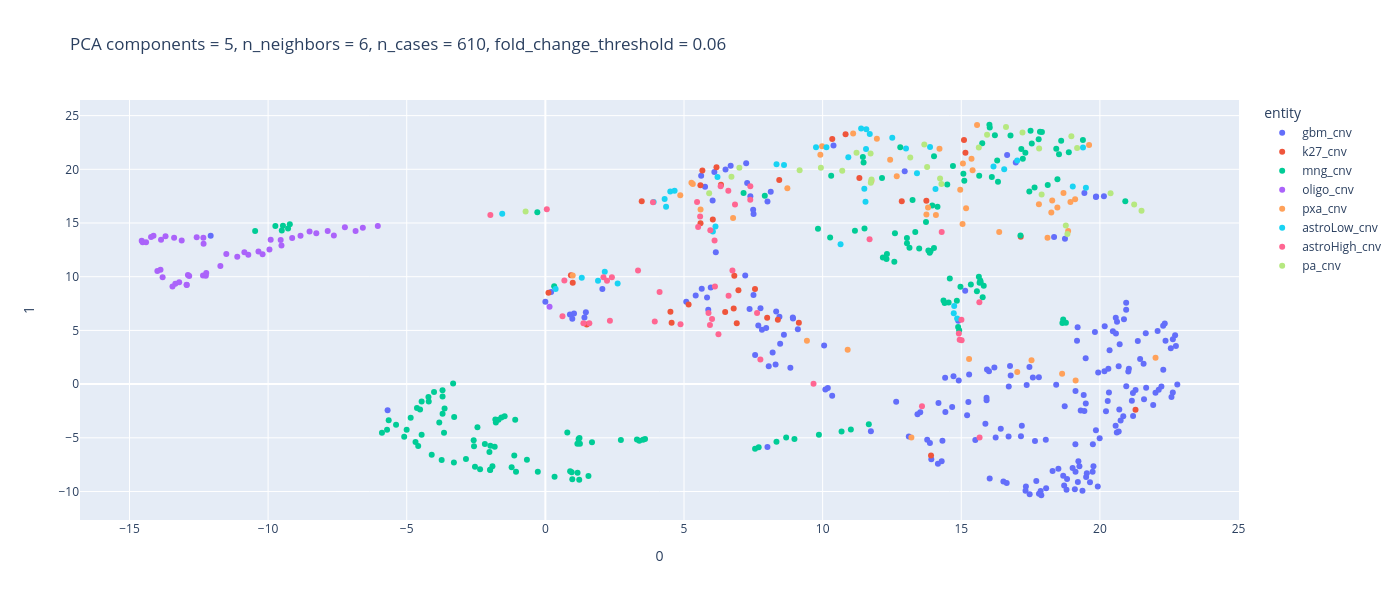

In [157]:
N_NEIGHBORS = 6

umap_2d = UMAP(n_neighbors=N_NEIGHBORS,n_epochs=500,random_state=1,spread=3,min_dist=0.5)
umap_2d.fit(denoize)

projections = umap_2d.transform(denoize)

fig = px.scatter(
    projections, x=0, y=1,
    title= f'PCA components = {PRINCIPAL_COMPONENTS}, n_neighbors = {N_NEIGHBORS}, n_cases = {df.shape[0]}, fold_change_threshold = {AMPLITUDE_THRESHOLD}' ,
    color=y_entity.astype(str), labels={'color': 'entity'},
    opacity=1
)

fig.update_layout(width=1000, height=600)

fig.show()